In [ ]:
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'

TIME = 'time'
VALUE = 'value'
NAME = 'name'


In [5]:
import sys
sys.path.append("..")  
from data_load.load_data import load_ordoneza_dataset
from pathlib import Path

dataset_b = load_ordoneza_dataset(Path("../dataset/UCI_ADL_Binary"), part='A')
print(dataset_b['activities'].head())
print(dataset_b.keys())

           start_time            end_time   activity
0 2011-11-28 02:27:59 2011-11-28 10:18:11   Sleeping
1 2011-11-28 10:21:24 2011-11-28 10:23:36  Toileting
2 2011-11-28 10:25:44 2011-11-28 10:33:00  Showering
3 2011-11-28 10:34:23 2011-11-28 10:43:00  Breakfast
4 2011-11-28 10:49:48 2011-11-28 10:51:13   Grooming
dict_keys(['activities', 'devices', 'device_areas', 'activity_list', 'device_list'])


In [6]:
import pandas as pd
import numpy as np

def label_data(activities: pd.DataFrame, events: pd.DataFrame, 
                                        time_col='time', activity_col='activity', other='other'):
    
    df_acts = activities.copy()
    df_devs = events.copy()

    df_acts['start_time'] = pd.to_datetime(df_acts['start_time'])
    df_acts['end_time'] = pd.to_datetime(df_acts['end_time'])
    df_devs[time_col] = pd.to_datetime(df_devs[time_col])

    eps = pd.Timedelta('1ns')
    mask_act_et_clsn = df_acts['end_time'].isin(df_devs[time_col])
    mask_act_st_clsn = df_acts['start_time'].isin(df_devs[time_col])
    df_acts.loc[df_acts[mask_act_et_clsn].index, 'end_time'] += eps
    df_acts.loc[df_acts[mask_act_st_clsn].index, 'start_time'] -= eps

    df_acts = df_acts.rename(columns={'start_time': time_col})

    # other
    df_other = df_acts[['end_time', activity_col]]
    df_other.loc[:, activity_col] = other
    df_other = df_other.rename(columns={'end_time': time_col})
    df_acts = df_acts.drop(columns='end_time')
    df_acts = pd.concat([df_acts, df_other.iloc[:-1]], ignore_index=True, axis=0) \
        .sort_values(by=time_col) \
        .reset_index(drop=True)

    df_acts['diff'] = df_acts[time_col].shift(-1) - df_acts[time_col]
    mask_invalid_others = (df_acts['diff'] < '1ns') & (df_acts[activity_col] == other)
    df_acts = df_acts[~mask_invalid_others][[time_col, activity_col]]

    df_acts = pd.concat([df_acts, pd.Series({
        time_col: activities.at[activities.index[-1], 'end_time'],
        activity_col: other
    }).to_frame().T]).reset_index(drop=True)

    df_label = df_acts.copy()
    df_label = df_label.sort_values(by=time_col).reset_index(drop=True)
    df_devs = df_devs.sort_values(by=time_col).reset_index(drop=True)

    if df_devs[time_col].iat[0] < df_label[time_col].iat[0]:
        df_label = pd.concat([df_label,
            pd.Series({
                time_col: df_devs.at[0, time_col] - pd.Timedelta('1ms'), 
                activity_col: other
            }).to_frame().T], axis=0, ignore_index=True)

    df_dev_tmp = df_devs.copy()
    df_act_tmp = df_label.copy().sort_values(by=time_col).reset_index(drop=True)

    df_dev_tmp[activity_col] = np.nan
    for col in set(df_devs.columns).difference(df_act_tmp.columns):
        df_act_tmp[col] = np.nan

    df = pd.concat([df_dev_tmp, df_act_tmp], ignore_index=True, axis=0)\
        .sort_values(by=time_col)\
        .reset_index(drop=True)

    df[activity_col] = df[activity_col].ffill()
    df = df.dropna().reset_index(drop=True)
    assert len(df) == len(df_devs)

    other_mask = (df[activity_col] == other)
    df.loc[other_mask, activity_col] = np.nan

    # print(df.head())
    df = df.dropna(subset=[time_col, activity_col]).reset_index(drop=True)

    y= df[[time_col, activity_col]].copy()
    X = df.drop(columns=activity_col).copy()

    # y = df[[time_col, activity_col]].dropna().reset_index(drop=True)
    # X = df.drop(columns=activity_col).reset_index(drop=True)

    # X = X.loc[y.index].reset_index(drop=True)

    return X, y

labeled_devices, labeled_activities = label_data(dataset_b['activities'], dataset_b['devices'])
print(labeled_activities.head())
print(labeled_devices.head())

# diff_mask = labeled_activities['time'].equals(labeled_devices['time'])
# print(diff_mask)



                  time   activity
0  2011-11-28 02:27:59   Sleeping
1  2011-11-28 10:18:11   Sleeping
2  2011-11-28 10:21:24  Toileting
3  2011-11-28 10:21:31  Toileting
4  2011-11-28 10:21:44  Toileting
                  time location      type     place  \
0  2011-11-28 02:27:59      Bed  Pressure   Bedroom   
1  2011-11-28 10:18:11      Bed  Pressure   Bedroom   
2  2011-11-28 10:21:24  Cabinet  Magnetic  Bathroom   
3  2011-11-28 10:21:31  Cabinet  Magnetic  Bathroom   
4  2011-11-28 10:21:44    Basin       PIR  Bathroom   

                      device value  
0       Bedroom_Bed_Pressure   1.0  
1       Bedroom_Bed_Pressure   0.0  
2  Bathroom_Cabinet_Magnetic   1.0  
3  Bathroom_Cabinet_Magnetic   0.0  
4         Bathroom_Basin_PIR   1.0  


In [51]:
import pandas as pd

def get_max_time_interval(df: pd.DataFrame, time_col: str = 'time'):

    df[time_col] = pd.to_datetime(df[time_col])
    time_diff = df[time_col].diff()
    max_time_diff = time_diff.max()

    return max_time_diff

df = labeled_activities

max_interval = get_max_time_interval(df)
print(f"max time interval：{max_interval}")

max time interval：0 days 10:13:45


In [52]:
# import pandas as pd
# import matplotlib.pyplot as plt

# def visualize_time_series(df: pd.DataFrame, time_col: str, value_col: str):

#     df = df.set_index(time_col)

#     # 绘制原始数据
#     plt.figure(figsize=(12, 6))
#     plt.plot(df[value_col], label='原始数据')

#     rolling_mean = df[value_col].rolling(window=10).mean()
#     plt.plot(rolling_mean, label='移动平均 (窗口=10)')

#     plt.title('时间序列数据可视化')
#     plt.xlabel('时间')
#     plt.ylabel(value_col)
#     plt.legend()
#     plt.show()

# # 示例用法（假设你的 DataFrame 叫做 df，时间戳列是 'time'，数值列是 'value'）
# visualize_time_series(labeled_devices, 'time', 'value')

In [69]:
def segment_by_activities_to_tensor(X: pd.DataFrame, y: pd.DataFrame, time_col='time', activity_col='activity'):
    """
    将数据流按活动变化分割成多对多的序列。

    Parameters
    ----------
    X : pd.DataFrame
        输入特征数据，包含时间列和特征列。
    y : pd.DataFrame
        标签数据，包含时间列和活动列。
    time_col : str, optional
        X 和 y 中表示时间的列名，默认为 'time'。
    activity_col : str, optional
        y 中表示活动的列名，默认为 'activity'。

    Returns
    -------
    Xt : np.ndarray
        形状为 (S, F, T) 的特征张量，其中：
        - S 是序列数（活动段数）
        - F 是特征数（X 的列数减去时间列）
        - T 是最长序列长度，短序列用 NaN 填充
    yt : np.ndarray
        形状为 (S, T) 的标签张量，每个时间步对应一个活动标签。

    Notes
    -----
    - 假设 X 和 y 的时间戳是对齐的。
    - 序列按活动变化分割，连续相同活动视为一个序列。
    - 输出张量中短序列用 NaN 填充以对齐最长序列。
    """
    # 输入校验
    if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.DataFrame):
        raise ValueError("X 和 y 必须是 pandas.DataFrame 类型")
    if time_col not in X.columns or time_col not in y.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 或 y 中找到")
    if activity_col not in y.columns:
        raise ValueError(f"活动列 '{activity_col}' 未在 y 中找到")

    # 复制数据并重置索引
    X = X.copy().reset_index(drop=True)
    y = y.copy().reset_index(drop=True)

    # 确保 X 和 y 的时间戳对齐
    if not X[time_col].equals(y[time_col]):
        raise ValueError("X 和 y 的时间列必须完全一致")

    # 按活动变化分配序列编号
    y['tmp'] = (y[activity_col] != y[activity_col].shift(1)).cumsum()

    # 计算序列数 (S)、最大序列长度 (T) 和特征数 (F)
    S = y['tmp'].iat[-1]  # 最后一个 tmp 值即序列总数
    T = y['tmp'].value_counts().max()  # 最长序列的长度
    F = len(X.columns) - 1  # 特征数，排除时间列

    # 初始化输出张量
    Xt = np.full((S, F, T), np.nan, dtype='object')  # 特征张量
    yt = np.full((S, T), np.nan, dtype='object')     # 标签张量（多对多）

    # 按序列填充数据
    for s, (_, grp) in enumerate(y.groupby('tmp')):
        # 提取当前序列的特征数据（排除时间列）
        X_tmp = X.loc[grp.index, X.columns != time_col].values
        X_tmp = np.swapaxes(X_tmp, 0, 1)  # 转置为 (F, 时间步)
        Xt[s, :, :X_tmp.shape[-1]] = X_tmp

        # 提取当前序列的活动标签
        y_tmp = y.loc[grp.index, activity_col].values
        yt[s, :y_tmp.shape[-1]] = y_tmp

    return Xt, yt

# 示例使用
if __name__ == "__main__":
    # 假设 labeled_activities 和 labeled_devices 已定义
    X_data = labeled_devices.copy()
    y_data = labeled_activities.copy()

    # 分割数据
    Xt, yt = segment_by_activities_to_tensor(X_data, y_data)
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")
    # print(f"Xt[0]:\n{Xt}")
    # print(f"yt[0]:\n{yt}")

Xt shape: (244, 5, 18), yt shape: (244, 18)


In [64]:
import pandas as pd
import numpy as np
import numpy.ma as ma

def segment_by_activities_to_tensor_mask(X: pd.DataFrame, y: pd.DataFrame, time_col='time', activity_col='activity'):
    """
    将数据流按活动变化分割成多对多的序列，并使用掩码处理 NaN 值。

    Parameters
    ----------
    X : pd.DataFrame
        输入特征数据，包含时间列和特征列。
    y : pd.DataFrame
        标签数据，包含时间列和活动列。
    time_col : str, optional
        X 和 y 中表示时间的列名，默认为 'time'。
    activity_col : str, optional
        y 中表示活动的列名，默认为 'activity'。

    Returns
    -------
    Xt : np.ma.MaskedArray
        形状为 (S, F, T) 的特征掩码数组，其中：
        - S 是序列数（活动段数）
        - F 是特征数（X 的列数减去时间列）
        - T 是最长序列长度，短序列用 NaN 填充，并被掩码
    yt : np.ma.MaskedArray
        形状为 (S, T) 的标签掩码数组，每个时间步对应一个活动标签。

    Notes
    -----
    - 假设 X 和 y 的时间戳是对齐的。
    - 序列按活动变化分割，连续相同活动视为一个序列。
    - 输出掩码数组中短序列用 NaN 填充，并被掩码。
    """
    # 输入校验 (保持不变)
    if not isinstance(X, pd.DataFrame) or not isinstance(y, pd.DataFrame):
        raise ValueError("X 和 y 必须是 pandas.DataFrame 类型")
    if time_col not in X.columns or time_col not in y.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 或 y 中找到")
    if activity_col not in y.columns:
        raise ValueError(f"活动列 '{activity_col}' 未在 y 中找到")

    # 复制数据并重置索引 (保持不变)
    X = X.copy().reset_index(drop=True)
    y = y.copy().reset_index(drop=True)

    # 确保 X 和 y 的时间戳对齐 (保持不变)
    if not X[time_col].equals(y[time_col]):
        raise ValueError("X 和 y 的时间列必须完全一致")

    # 按活动变化分配序列编号 (保持不变)
    y['tmp'] = (y[activity_col] != y[activity_col].shift(1)).cumsum()

    # 计算序列数 (S)、最大序列长度 (T) 和特征数 (F) (保持不变)
    S = y['tmp'].iat[-1]
    T = y['tmp'].value_counts().max()
    F = len(X.columns) - 1

    # 初始化输出掩码数组
    Xt = ma.masked_array(np.full((S, F, T), np.nan, dtype='object'))  # 特征掩码数组
    yt = ma.masked_array(np.full((S, T), np.nan, dtype='object'))    # 标签掩码数组

    # 按序列填充数据
    for s, (_, grp) in enumerate(y.groupby('tmp')):
        # 提取当前序列的特征数据（排除时间列）
        X_tmp = X.loc[grp.index, X.columns != time_col].values
        X_tmp = np.swapaxes(X_tmp, 0, 1)
        Xt[s, :, :X_tmp.shape[-1]] = X_tmp

        # 提取当前序列的活动标签
        y_tmp = y.loc[grp.index, activity_col].values
        yt[s, :y_tmp.shape[-1]] = y_tmp

    return Xt, yt

# 示例使用
if __name__ == "__main__":
    # 假设 labeled_activities 和 labeled_devices 已定义
    X_data = labeled_devices.copy()
    y_data = labeled_activities.copy()

    # 分割数据
    Xt, yt = segment_by_activities_to_tensor_mask(X_data, y_data)
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")
    print(f"Xt[0]:\n{Xt}")
    print(f"yt[0]:\n{yt}")

Xt shape: (244, 5, 18), yt shape: (244, 18)
Xt[0]:
[[['Bed' 'Bed' nan ... nan nan nan]
  ['Pressure' 'Pressure' nan ... nan nan nan]
  ['Bedroom' 'Bedroom' nan ... nan nan nan]
  ['Bedroom_Bed_Pressure' 'Bedroom_Bed_Pressure' nan ... nan nan nan]
  [1.0 0.0 nan ... nan nan nan]]

 [['Cabinet' 'Cabinet' 'Basin' ... nan nan nan]
  ['Magnetic' 'Magnetic' 'PIR' ... nan nan nan]
  ['Bathroom' 'Bathroom' 'Bathroom' ... nan nan nan]
  ['Bathroom_Cabinet_Magnetic' 'Bathroom_Cabinet_Magnetic'
   'Bathroom_Basin_PIR' ... nan nan nan]
  [1.0 0.0 1.0 ... nan nan nan]]

 [['Shower' 'Shower' nan ... nan nan nan]
  ['PIR' 'PIR' nan ... nan nan nan]
  ['Bathroom' 'Bathroom' nan ... nan nan nan]
  ['Bathroom_Shower_PIR' 'Bathroom_Shower_PIR' nan ... nan nan nan]
  [1.0 0.0 nan ... nan nan nan]]

 ...

 [['Toilet' 'Toilet' nan ... nan nan nan]
  ['Flush' 'Flush' nan ... nan nan nan]
  ['Bathroom' 'Bathroom' nan ... nan nan nan]
  ['Bathroom_Toilet_Flush' 'Bathroom_Toilet_Flush' nan ... nan nan nan]
  [1

(762, 6)
(762, 2)
Xt shape: (892, 7, 6), yt shape: (892, 7, 1)
Xt[0]:
[[[Timestamp('2011-11-28 02:27:59') 'Bed' 'Pressure' 'Bedroom'
   'Bedroom_Bed_Pressure' 1.0]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  ...
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]]

 [[Timestamp('2011-11-28 10:18:11') 'Bed' 'Pressure' 'Bedroom'
   'Bedroom_Bed_Pressure' 0.0]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  ...
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]]

 [[Timestamp('2011-11-28 10:18:11') 'Bed' 'Pressure' 'Bedroom'
   'Bedroom_Bed_Pressure' 0.0]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  ...
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]]

 ...

 [[Timestamp('2011-12-11 15:30:14') 'Toilet' 'Flush' 'Bathroom'
   'Bathroom_Toilet_Flush' 0.0]
  [nan nan nan nan nan nan]
  [nan nan nan nan nan nan]
  ...
  [nan nan nan nan nan nan]
  [nan nan n

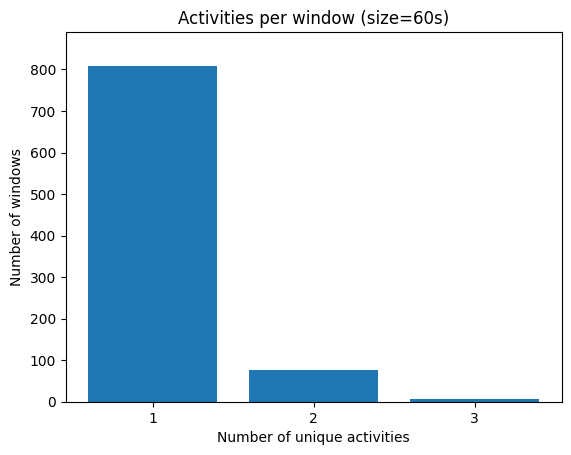

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def segment_by_time_to_tensor(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                   stride: str = None, time_col: str = 'time', activity_col: str = 'activity',
                   drop_empty_intervals: bool = True) -> tuple:
    # 输入校验
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 中找到")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta
    window_size = pd.Timedelta(window_size)
    stride = pd.Timedelta(stride) if stride is not None else window_size

    # 复制并按时间排序
    df = X.copy().sort_values(by=time_col)
    st = X[time_col].iloc[0] - pd.Timedelta('1s')
    et = X[time_col].iloc[-1] + pd.Timedelta('1s')

    print(X.shape)
    print(y.shape)


    # 生成窗口起始时间
    st_windows = pd.date_range(st, et - window_size, freq=stride)

    # 分割数据
    X_list = []
    y_list = []
    max_seq_length = 0

    if drop_empty_intervals:
        times = df[time_col].copy()
        win_st = st
        i = 0
        while win_st + window_size <= et:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            if not event_idxs.empty:
                X_list.append(X.iloc[event_idxs].copy())
                if y is not None:
                    y_list.append(y.iloc[event_idxs].copy())
                max_seq_length = max(max_seq_length, len(X_list[i]))
                win_st = win_st + stride
                i += 1
            else:
                next_event_time = times[win_st < times].iloc[0]
                win_min_idx_not_containing_ev = (st_windows <= next_event_time - window_size).cumsum().max() - 1
                if win_min_idx_not_containing_ev == len(st_windows) - 1:
                    break
                win_st = st_windows[win_min_idx_not_containing_ev + 1]
    else:
        for win_st in st_windows:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            X_list.append(X.iloc[event_idxs].copy())
            if y is not None:
                y_list.append(y.iloc[event_idxs].copy())
            max_seq_length = max(max_seq_length, len(X_list[-1]))

    # 构建张量
    S = len(X_list)
    F = len(X.columns)
    T = max_seq_length
    Xt = np.full((S, T, F), np.nan, dtype='object')

    if y is not None:
        Fy = 1  # 固定为 1，只存储 activity 列
        yt = np.full((S, T, Fy), np.nan, dtype='object')
    else:
        yt = None

    # 填充数据
    for s in range(S):
        X_tmp = X_list[s].values
        Xt[s, :X_tmp.shape[0], :] = X_tmp
        if y is not None:
            y_tmp = y_list[s][activity_col].values  # 只提取 activity 列
            if y_tmp.size > 0:
                yt[s, :y_tmp.shape[0], 0] = y_tmp  # 填充到 yt 的第 0 维

    return Xt, yt

def plot_activities_per_window(Xt: np.ndarray, yt: np.ndarray, window_size: str, 
                             scale: str = 'linear', time_col_idx: int = 0, 
                             activity_col_idx: int = 0) -> plt.Figure:  # 修改默认值为 0
    if yt is None:
        raise ValueError("yt 必须提供以计算活动分布")
    if not isinstance(Xt, np.ndarray) or not isinstance(yt, np.ndarray):
        raise ValueError("Xt 和 yt 必须是 numpy.ndarray 类型")

    # 提取活动列（现在 yt 的最后一个维度大小为 1）
    yt_activities = yt[:, :, activity_col_idx]
    counts_per_window = []
    for window in yt_activities:
        valid_acts = window[~pd.isnull(window)]
        if len(valid_acts) > 0:
            unique_acts = len(np.unique(valid_acts))
            counts_per_window.append(unique_acts)

    if not counts_per_window:
        print("警告：没有有效的窗口数据可绘制")
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "无数据可显示", horizontalalignment='center', verticalalignment='center')
        return fig

    bins, counts = np.unique(counts_per_window, return_counts=True)
    df = pd.DataFrame({'activity per window': bins, 'count': counts})

    fig, ax = plt.subplots()
    ax.bar(df['activity per window'], df['count'])
    ax.set_title(f'Activities per window (size={window_size})')
    ax.set_xlabel('Number of unique activities')
    ax.set_ylabel('Number of windows')
    ax.set_xticks(df['activity per window'])

    if scale == 'log':
        ax.set_yscale('log')
        ax.set_ylim(0.1, 10**np.ceil(np.log10(df['count'].max())))
    else:
        ax.set_ylim(0, df['count'].max() * 1.1)

    return fig

# 示例使用
if __name__ == "__main__":
    # 假设 labeled_activities 和 labeled_devices 已定义
    X_data = labeled_devices
    y_data = labeled_activities

    # 分割数据
    Xt, yt = segment_by_time_to_tensor(X_data, y_data, window_size='60s', stride='30s', drop_empty_intervals=True)
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")
    print(f"Xt[0]:\n{Xt}")
    print(f"yt[0]:\n{yt}")

    # 可视化
    fig = plot_activities_per_window(Xt, yt, window_size='60s', scale='linear')
    plt.show()

In [67]:
import pandas as pd
import numpy as np
import numpy.ma as ma

def segment_by_time_to_tensor_mask(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                            stride: str = None, time_col: str = 'time', activity_col: str = 'activity',
                            drop_empty_intervals: bool = True) -> tuple:
    # 输入校验 (保持不变)
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 中找到")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta (保持不变)
    window_size = pd.Timedelta(window_size)
    stride = pd.Timedelta(stride) if stride is not None else window_size

    # 复制并按时间排序 (保持不变)
    df = X.copy().sort_values(by=time_col)
    st = X[time_col].iloc[0] - pd.Timedelta('1s')
    et = X[time_col].iloc[-1] + pd.Timedelta('1s')

    print(X.shape)
    print(y.shape)

    # 生成窗口起始时间 (保持不变)
    st_windows = pd.date_range(st, et - window_size, freq=stride)

    # 分割数据 (保持不变)
    X_list = []
    y_list = []
    max_seq_length = 0

    if drop_empty_intervals:
        times = df[time_col].copy()
        win_st = st
        i = 0
        while win_st + window_size <= et:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            if not event_idxs.empty:
                X_list.append(X.iloc[event_idxs].copy())
                if y is not None:
                    y_list.append(y.iloc[event_idxs].copy())
                max_seq_length = max(max_seq_length, len(X_list[i]))
                win_st = win_st + stride
                i += 1
            else:
                next_event_time = times[win_st < times].iloc[0]
                win_min_idx_not_containing_ev = (st_windows <= next_event_time - window_size).cumsum().max() - 1
                if win_min_idx_not_containing_ev == len(st_windows) - 1:
                    break
                win_st = st_windows[win_min_idx_not_containing_ev + 1]
    else:
        for win_st in st_windows:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            X_list.append(X.iloc[event_idxs].copy())
            if y is not None:
                y_list.append(y.iloc[event_idxs].copy())
            max_seq_length = max(max_seq_length, len(X_list[-1]))

    # 构建掩码数组
    S = len(X_list)
    F = len(X.columns)
    T = max_seq_length
    Xt = ma.masked_array(np.full((S, T, F), np.nan, dtype='object'))

    if y is not None:
        Fy = 1  # 固定为 1，只存储 activity 列
        yt = ma.masked_array(np.full((S, T, Fy), np.nan, dtype='object'))
    else:
        yt = None

    # 填充数据
    for s in range(S):
        X_tmp = X_list[s].values
        Xt[s, :X_tmp.shape[0], :] = X_tmp
        if y is not None:
            y_tmp = y_list[s][activity_col].values  # 只提取 activity 列
            if y_tmp.size > 0:
                yt[s, :y_tmp.shape[0], 0] = y_tmp  # 填充到 yt 的第 0 维

    return Xt, yt


# 示例使用
if __name__ == "__main__":
    # 假设 labeled_activities 和 labeled_devices 已定义
    X_data = labeled_devices
    y_data = labeled_activities

    # 分割数据
    Xt, yt = segment_by_time_to_tensor_mask(X_data, y_data, window_size='60s', stride='30s', drop_empty_intervals=True)
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")
    # print(f"Xt[0]:\n{Xt}")
    print(f"yt[0]:\n{yt}")

(762, 6)
(762, 2)
Xt shape: (892, 7, 6), yt shape: (892, 7, 1)
yt[0]:
[[['Sleeping']
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [['Sleeping']
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [['Sleeping']
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 ...

 [['Toileting']
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [['Grooming']
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]

 [['Grooming']
  [nan]
  [nan]
  ...
  [nan]
  [nan]
  [nan]]]


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def segment_by_time_to_csv(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                         stride: str = None, time_col: str = 'time', activity_col: str = 'activity',
                         drop_empty_intervals: bool = True) -> tuple:
    # 输入校验
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 中找到")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta
    window_size = pd.Timedelta(window_size)
    if stride is None:
        stride = window_size  # 如果 stride 为 None，默认使用窗口大小作为步长
    else:
        if isinstance(stride, str) and '*' in stride:
            time_part, multiplier_part = stride.split('*')
            time_delta = pd.Timedelta(time_part)
            multiplier = float(multiplier_part)
            stride = time_delta * multiplier
        else:
            stride = pd.Timedelta(stride)

    # 复制并按时间排序
    df = X.copy().sort_values(by=time_col)
    st = X[time_col].iloc[0] - pd.Timedelta('1s')
    et = X[time_col].iloc[-1] + pd.Timedelta('1s')

    # 生成窗口起始时间
    st_windows = pd.date_range(st, et - window_size, freq=stride)

    # 分割数据
    X_list = []
    y_list = []

    if drop_empty_intervals:
        times = df[time_col].copy()
        win_st = st
        while win_st + window_size <= et:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            if not event_idxs.empty:
                X_list.append(X.iloc[event_idxs].copy())
                if y is not None:
                    y_list.append(y.iloc[event_idxs].copy())
                win_st = win_st + stride
            else:
                next_event_time = times[win_st < times].iloc[0]
                win_min_idx_not_containing_ev = (st_windows <= next_event_time - window_size).cumsum().max() - 1
                if win_min_idx_not_containing_ev == len(st_windows) - 1:
                    break
                win_st = st_windows[win_min_idx_not_containing_ev + 1]
    else:
        for win_st in st_windows:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            X_list.append(X.iloc[event_idxs].copy())
            if y is not None:
                y_list.append(y.iloc[event_idxs].copy())

    if y is not None:
        return X_list, y_list
    else:
        return X_list, None


In [59]:
from collections import Counter
def get_most_frequent_activity_labels(y_list, output_path):
    """
    遍历所有窗口的 y_list，计算每个窗口中最频繁的活动，并将这些活动标签存储在一个列表中，然后将这个列表保存到本地文件。
    """
    most_frequent_labels = []
    for y_seg in y_list:
        if y_seg.empty:
            most_frequent_labels.append(None)  # 或者你可以选择其他表示空窗口的方式
            continue
        counts = Counter(y_seg[ACTIVITY])
        most_common_activity = counts.most_common(1)[0][0]
        most_frequent_labels.append(most_common_activity)

    # 将列表保存到本地文件
    with open(output_path, 'w') as f:
        for label in most_frequent_labels:
            f.write(str(label) + '\n')
    print(f"ground_truth '{output_path}'")


import os

# 示例使用
if __name__ == "__main__":
    # 假设 labeled_activities 和 labeled_devices 已定义
    X_data = labeled_devices
    y_data = labeled_activities

    # 分割数据
    stride_value = '60s*0.8'
    X_list, y_list = segment_by_time_to_csv(X_data, y_data, window_size='60s', stride=stride_value, drop_empty_intervals=True)
    print(f"X_list length: {len(X_list)}, y_list length: {len(y_list) if y_list else 0}")
    print(f"X_list[0]:\n{X_list[0]}")
    if y_list:
        get_most_frequent_activity_labels(y_list, 'ground_truth.txt')
    

     # 保存 X_list
    output_dir = "segmented_data"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, df in enumerate(X_list):
        df.to_csv(os.path.join(output_dir, f"X_segment_{i}.csv"), index=False)


X_list length: 544, y_list length: 544
X_list[0]:
                  time location      type    place                device value
0  2011-11-28 02:27:59      Bed  Pressure  Bedroom  Bedroom_Bed_Pressure   1.0
ground_truth 'ground_truth.txt'


In [70]:
import pandas as pd

def segment_by_time_with_stauts(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                                stride: str = None, time_col: str = 'time', activity_col: str = 'activity',
                                drop_empty_intervals: bool = True) -> tuple:
    # 输入校验
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 中找到")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta
    window_size = pd.Timedelta(window_size)
    if stride is None:
        stride = window_size  # 如果 stride 为 None，默认使用窗口大小作为步长
    else:
        if isinstance(stride, str) and '*' in stride:
            time_part, multiplier_part = stride.split('*')
            time_delta = pd.Timedelta(time_part)
            multiplier = float(multiplier_part)
            stride = time_delta * multiplier
        else:
            stride = pd.Timedelta(stride)

    # 复制并按时间排序
    df = X.copy().sort_values(by=time_col)
    st = X[time_col].iloc[0] - pd.Timedelta('1s')
    et = X[time_col].iloc[-1] + pd.Timedelta('1s')

    # 生成窗口起始时间
    st_windows = pd.date_range(st, et - window_size, freq=stride)

    # 分割数据
    X_list = []
    y_list = []

    if drop_empty_intervals:
        times = df[time_col].copy()
        win_st = st
        while win_st + window_size <= et:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            if not event_idxs.empty:
                X_segment = X.iloc[event_idxs].copy()
                X_list.append(X_segment)
                if y is not None:
                    y_list.append(y.iloc[event_idxs].copy())
                win_st = win_st + stride
            else:
                next_event_time = times[win_st < times].iloc[0]
                win_min_idx_not_containing_ev = (st_windows <= next_event_time - window_size).cumsum().max() - 1
                if win_min_idx_not_containing_ev == len(st_windows) - 1:
                    break
                win_st = st_windows[win_min_idx_not_containing_ev + 1]
    else:
        for win_st in st_windows:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            X_segment = X.iloc[event_idxs].copy()
            X_list.append(X_segment)
            if y is not None:
                y_list.append(y.iloc[event_idxs].copy())

    sensor_status_list = []
    for i, X_segment in enumerate(X_list):
        sensor_status = pd.Series(index=X_segment.index)
        prev_segment = X_list[i - 1] if i > 0 else None
        next_segment = X_list[i + 1] if i < len(X_list) - 1 else None

        for sensor in X_segment.columns.difference([time_col]):  # 遍历传感器列
            current_active = X_segment[sensor].any()
            prev_active = prev_segment[sensor].any() if prev_segment is not None else False
            next_active = next_segment[sensor].any() if next_segment is not None else False

            status = 'inactive'  # 默认状态
            if current_active:
                if prev_active and next_active:
                    status = 'keep_on'
                elif prev_active:
                    status = 'already_active'
                elif next_active:
                    status = 'persistent'
                else:
                    status = 'inner'

            sensor_status[X_segment.index] = status  # 为当前窗口的所有行设置状态

        X_segment['sensor_status'] = sensor_status  # 添加传感器状态列
        sensor_status_list.append(sensor_status)

    if y is not None:
        return X_list, y_list
    else:
        return X_list, None

In [71]:
from collections import Counter
import os

def get_most_frequent_activity_labels(y_list, output_path):
    """
    遍历所有窗口的 y_list，计算每个窗口中最频繁的活动，并将这些活动标签存储在一个列表中，然后将这个列表保存到本地文件。
    """
    most_frequent_labels = []
    for y_seg in y_list:
        if y_seg.empty:
            most_frequent_labels.append(None)  # 或者你可以选择其他表示空窗口的方式
            continue
        counts = Counter(y_seg[ACTIVITY])
        most_common_activity = counts.most_common(1)[0][0]
        most_frequent_labels.append(most_common_activity)

    # 将列表保存到本地文件
    with open(output_path, 'w') as f:
        for label in most_frequent_labels:
            f.write(str(label) + '\n')
    print(f"ground_truth '{output_path}'")

# 示例使用
if __name__ == "__main__":
    # 假设 labeled_activities 和 labeled_devices 已定义
    X_data = labeled_devices
    y_data = labeled_activities

    # 分割数据
    stride_value = '60s*0.8'
    X_list, y_list = segment_by_time_with_stauts(X_data, y_data, window_size='60s', stride=stride_value, drop_empty_intervals=True)
    print(f"X_list length: {len(X_list)}, y_list length: {len(y_list) if y_list else 0}")
    if y_list:
        get_most_frequent_activity_labels(y_list, 'ground_truth.txt')
    

     # 保存 X_list
    output_dir = "segmented_data_with_status"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, df in enumerate(X_list):
        df.to_csv(os.path.join(output_dir, f"X_segment_{i}.csv"), index=False)


X_list length: 544, y_list length: 544
ground_truth 'ground_truth.txt'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

def segment_by_time_to_tensor(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                                stride: str = None, time_col: str = 'time', activity_col: str = 'activity',
                                drop_empty_intervals: bool = True) -> tuple:
    # 输入校验
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 中找到")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta
    window_size = pd.Timedelta(window_size)
    stride = pd.Timedelta(stride) if stride is not None else window_size

    # 复制并按时间排序
    df = X.copy().sort_values(by=time_col)
    st = X[time_col].iloc[0] - pd.Timedelta('1s')
    et = X[time_col].iloc[-1] + pd.Timedelta('1s')

    # 生成窗口起始时间
    st_windows = pd.date_range(st, et - window_size, freq=stride)

    # 分割数据
    X_list = []
    y_list = []
    max_seq_length = 0

    if drop_empty_intervals:
        times = df[time_col].copy()
        win_st = st
        i = 0
        while win_st + window_size <= et:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            if not event_idxs.empty:
                X_list.append(X.iloc[event_idxs].copy())
                if y is not None:
                    y_list.append(y.iloc[event_idxs].copy())
                max_seq_length = max(max_seq_length, len(X_list[i]))
                win_st = win_st + stride
                i += 1
            else:
                next_event_time = times[win_st < times].iloc[0]
                win_min_idx_not_containing_ev = (st_windows <= next_event_time - window_size).cumsum().max() - 1
                if win_min_idx_not_containing_ev == len(st_windows) - 1:
                    break
                win_st = st_windows[win_min_idx_not_containing_ev + 1]
    else:
        for win_st in st_windows:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            X_list.append(X.iloc[event_idxs].copy())
            if y is not None:
                y_list.append(y.iloc[event_idxs].copy())
            max_seq_length = max(max_seq_length, len(X_list[-1]))

    # 构建张量
    S = len(X_list)
    F = len(X.columns)
    T = max_seq_length
    Xt = np.full((S, T, F), np.nan, dtype='object')

    if y is not None:
        Fy = 1  # 固定为 1，只存储 activity 列
        yt = np.full((S, T, Fy), np.nan, dtype='object')
    else:
        yt = None

    # 填充数据
    for s in range(S):
        X_tmp = X_list[s].values
        Xt[s, :X_tmp.shape[0], :] = X_tmp
        if y is not None:
            y_tmp = y_list[s][activity_col].values  # 只提取 activity 列
            if y_tmp.size > 0:
                yt[s, :y_tmp.shape[0], 0] = y_tmp  # 填充到 yt 的第 0 维

    # 填充未更新值
    for s in range(S):
        for t in range(1, T):
            if np.all(pd.isnull(Xt[s, t, :])):
                Xt[s, t, :] = Xt[s, t - 1, :]
            if y is not None and pd.isnull(yt[s, t, 0]):
                yt[s, t, 0] = yt[s, t - 1, 0]

    # Label Encoding for Xt
    for f in range(F):
        if isinstance(Xt[0, 0, f], str):
            le_x = LabelEncoder()
            unique_values = np.unique(Xt[:, :, f][~pd.isnull(Xt[:, :, f])])
            le_x.fit(unique_values)
            for s in range(S):
                for t in range(T):
                    if not pd.isnull(Xt[s, t, f]):
                        Xt[s, t, f] = le_x.transform([Xt[s, t, f]])[0]
            Xt[:, :, f] = Xt[:, :, f].astype(np.float64)

    # Label Encoding for yt
    if y is not None:
        le_y = LabelEncoder()
        # 将 yt 转换为 object 类型，以便处理字符串和 NaN
        yt_obj = yt.astype(object)
        # 找到非 NaN 的唯一值
        unique_labels = np.unique(yt_obj[~pd.isnull(yt_obj)])
        le_y.fit(unique_labels)
        for s in range(S):
            for t in range(T):
                if not pd.isnull(yt[s, t, 0]):
                    yt[s, t, 0] = le_y.transform([yt[s, t, 0]])[0]
        yt = yt.astype(np.float64)

    return Xt, yt

if __name__ == "__main__":
    X_data = labeled_devices.copy()
    y_data = labeled_activities.copy()

    # 分割数据
    Xt, yt = segment_by_time_to_tensor(X_data, y_data,stride='48s')
    print(f"Xt shape: {Xt.shape}, yt shape: {yt.shape}")
    print(f"Xt[0]:\n{Xt[0]}")
    print(f"yt[0]:\n{yt[0]}")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def segment_by_time(X: pd.DataFrame, y: pd.DataFrame = None, window_size: str = '60s', 
                    stride: str = None, time_col: str = 'time', activity_col: str = 'activity',
                    drop_empty_intervals: bool = True) -> tuple:
    # 输入校验
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X 必须是 pandas.DataFrame 类型")
    if y is not None and not isinstance(y, pd.DataFrame):
        raise ValueError("y 如果提供，必须是 pandas.DataFrame 类型")
    if time_col not in X.columns:
        raise ValueError(f"时间列 '{time_col}' 未在 X 中找到")
    if y is not None and (time_col not in y.columns or activity_col not in y.columns):
        raise ValueError(f"y 中必须包含时间列 '{time_col}' 和活动列 '{activity_col}'")

    # 转换为 Timedelta
    window_size = pd.Timedelta(window_size)
    if stride is None:
        stride = window_size  # 如果 stride 为 None，默认使用窗口大小作为步长
    else:
        if isinstance(stride, str) and '*' in stride:
            time_part, multiplier_part = stride.split('*')
            time_delta = pd.Timedelta(time_part)
            multiplier = float(multiplier_part)
            stride = time_delta * multiplier
        else:
            stride = pd.Timedelta(stride)

    # 复制并按时间排序
    df = X.copy().sort_values(by=time_col)
    st = X[time_col].iloc[0] - pd.Timedelta('1s')
    et = X[time_col].iloc[-1] + pd.Timedelta('1s')

    # 生成窗口起始时间
    st_windows = pd.date_range(st, et - window_size, freq=stride)

    # 分割数据
    X_list = []
    y_list = []

    if drop_empty_intervals:
        times = df[time_col].copy()
        win_st = st
        while win_st + window_size <= et:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            if not event_idxs.empty:
                X_list.append(X.iloc[event_idxs].copy())
                if y is not None:
                    y_list.append(y.iloc[event_idxs].copy())
                win_st = win_st + stride
            else:
                next_event_time = times[win_st < times].iloc[0]
                win_min_idx_not_containing_ev = (st_windows <= next_event_time - window_size).cumsum().max() - 1
                if win_min_idx_not_containing_ev == len(st_windows) - 1:
                    break
                win_st = st_windows[win_min_idx_not_containing_ev + 1]
    else:
        for win_st in st_windows:
            win = (win_st, win_st + window_size)
            event_idxs = df[(win[0] <= df[time_col]) & (df[time_col] < win[1])].index
            X_list.append(X.iloc[event_idxs].copy())
            if y is not None:
                y_list.append(y.iloc[event_idxs].copy())

    if y is not None:
        return X_list, y_list
    else:
        return X_list, None

In [8]:
# 假设 dataset 已经被加载
X = labeled_devices.copy()
y = labeled_activities.copy()
# 分割数据
X_segments, y_segments = segment_by_time(X, y, window_size='60s', stride='48s')


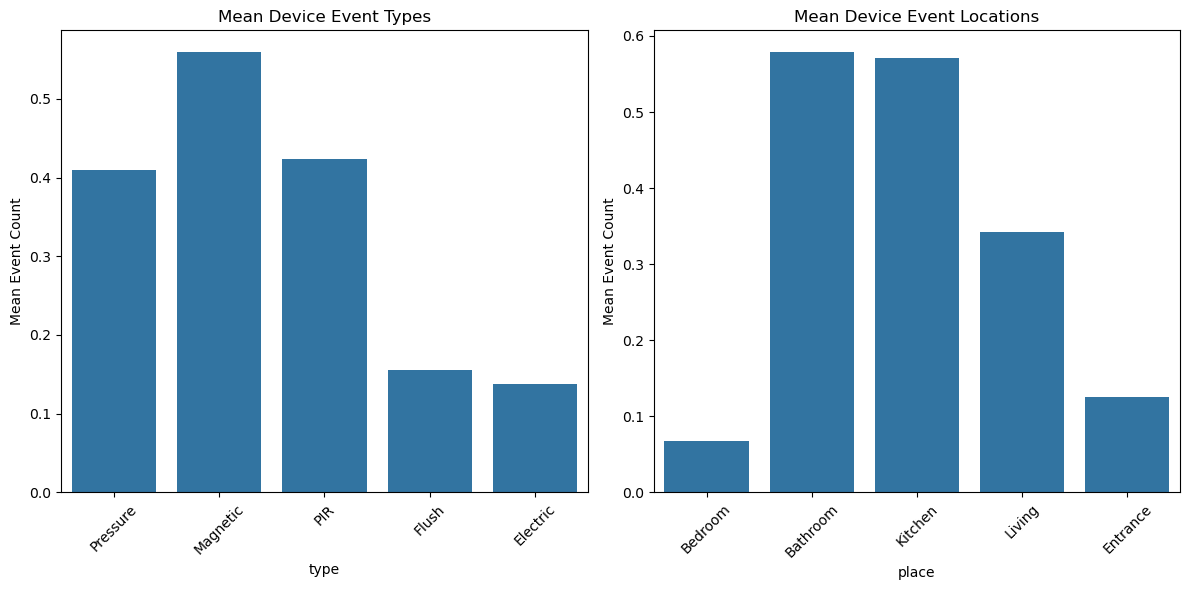

In [9]:
# 收集统计特征
device_type_counts_list = []
device_location_counts_list = []

for X_seg in X_segments:
    device_type_counts_list.append(X_seg['type'].value_counts())
    device_location_counts_list.append(X_seg['place'].value_counts())

# 将统计特征合并为一个 DataFrame
device_type_counts_df = pd.concat(device_type_counts_list, axis=1).fillna(0)
device_location_counts_df = pd.concat(device_location_counts_list, axis=1).fillna(0)

# 计算平均统计特征
mean_device_type_counts = device_type_counts_df.mean(axis=1)
mean_device_location_counts = device_location_counts_df.mean(axis=1)

# 可视化平均统计特征
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=mean_device_type_counts.index, y=mean_device_type_counts.values)
plt.title('Mean Device Event Types')
plt.ylabel('Mean Event Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=mean_device_location_counts.index, y=mean_device_location_counts.values)
plt.title('Mean Device Event Locations')
plt.ylabel('Mean Event Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

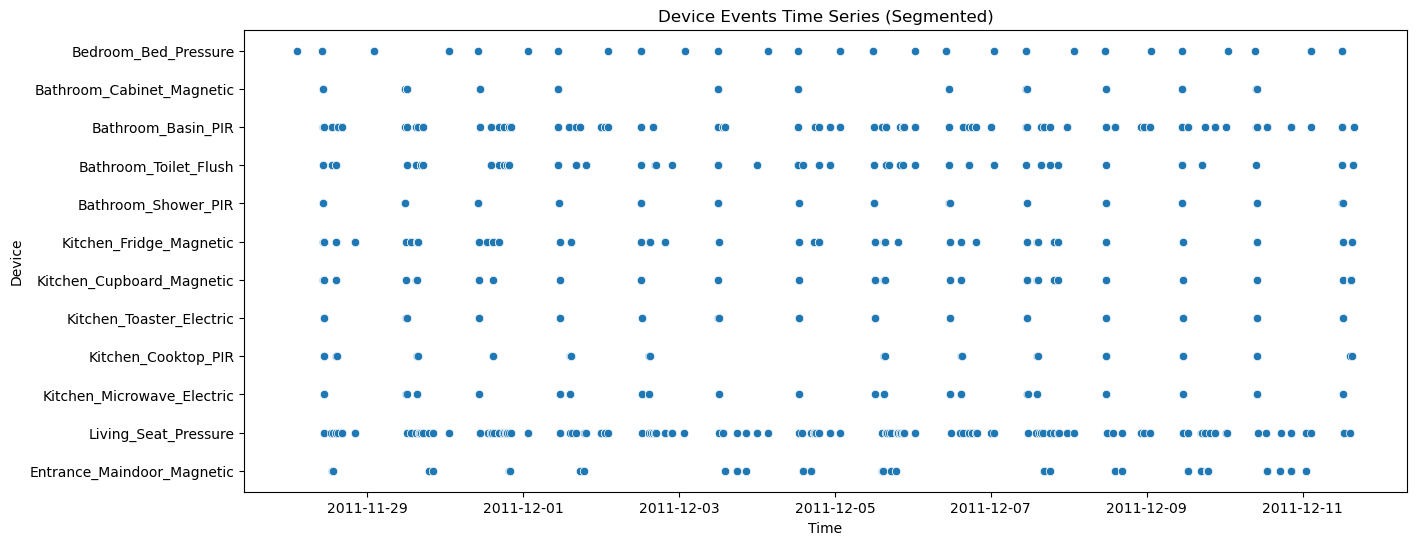

In [10]:
# 将分割后的数据合并为一个 DataFrame
X_merged = pd.concat(X_segments)
X_merged['time'] = pd.to_datetime(X_merged['time'])

# 绘制设备事件时间序列图
plt.figure(figsize=(15, 6))
sns.scatterplot(x='time', y='device', data=X_merged)
plt.title('Device Events Time Series (Segmented)')
plt.xlabel('Time')
plt.ylabel('Device')
plt.show()